In [4]:
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import numpy as np

In [5]:
np.version.version

'1.16.6'

In [6]:
def parse_data(path):
    for l in open(path,'r'):
        yield json.loads(l)
    

# Data preprocessing

In [7]:
data = list(parse_data('./Sarcasm_Headlines_Dataset_v2.json'))
heads,labels = [],[]
is_sarc,isnt_sarc = [],[]
for item in data:
    heads.append(item['headline'])
    labels.append(item['is_sarcastic'])
    if item['is_sarcastic'] == 1:
        is_sarc.append(item['headline'])
    if item['is_sarcastic'] == 0:
        isnt_sarc.append(item['headline'])


In [8]:
len(data)

28619

In [9]:
data[4]

{'is_sarcastic': 1,
 'headline': "mother comes pretty close to using word 'streaming' correctly",
 'article_link': 'https://www.theonion.com/mother-comes-pretty-close-to-using-word-streaming-cor-1819575546'}

In [10]:
def tokenize(texts): # input list of texts(strings)
    tokd = []
    for sent in texts:
        sent = nltk.word_tokenize(sent)
        for each in sent:
            tokd.append(each)
    return tokd

is_sarc_tokd = tokenize(is_sarc)
isnt_sarc_tokd = tokenize(isnt_sarc)

        

In [11]:
isnt_sarc_tokd[:12]

['dem',
 'rep.',
 'totally',
 'nails',
 'why',
 'congress',
 'is',
 'falling',
 'short',
 'on',
 'gender',
 ',']

In [12]:
stopwords = nltk.corpus.stopwords.words('english')

In [13]:
def unw_filter(pos_tagged):
    word, tag = pos_tagged
    if not word.isalpha() or word in stopwords:
        return False
    return True
is_sarc_words = [w for w,tag in filter(unw_filter,nltk.pos_tag(is_sarc_tokd))]
isnt_sarc_words = [w for w,tag in filter(unw_filter,nltk.pos_tag(isnt_sarc_tokd))]

In [14]:
is_sarc_words[:15]

['thirtysomething',
 'scientists',
 'unveil',
 'doomsday',
 'clock',
 'hair',
 'loss',
 'inclement',
 'weather',
 'prevents',
 'liar',
 'getting',
 'work',
 'mother',
 'comes']

In [15]:
isnt_sarc_words[:15]

['dem',
 'totally',
 'nails',
 'congress',
 'falling',
 'short',
 'gender',
 'racial',
 'equality',
 'eat',
 'veggies',
 'deliciously',
 'different',
 'recipes',
 'white']

# Feature Extraction

In [16]:
sarc_fd = nltk.FreqDist(is_sarc_words)
not_sarc_fd = nltk.FreqDist(isnt_sarc_words)
common_set = set(sarc_fd).intersection(not_sarc_fd)

sarc_fd.most_common(15)

[('man', 1269),
 ('new', 981),
 ('report', 515),
 ('area', 487),
 ('woman', 387),
 ('nation', 387),
 ('trump', 381),
 ('one', 295),
 ('time', 276),
 ('day', 265),
 ('still', 247),
 ('study', 241),
 ('like', 237),
 ('get', 224),
 ('back', 217)]

In [17]:
not_sarc_fd.most_common(25)

[('trump', 1401),
 ('new', 670),
 ('donald', 455),
 ('says', 349),
 ('women', 310),
 ('one', 249),
 ('people', 238),
 ('world', 235),
 ('man', 233),
 ('obama', 232),
 ('first', 228),
 ('day', 214),
 ('gop', 213),
 ('make', 213),
 ('like', 205),
 ('could', 203),
 ('clinton', 201),
 ('get', 198),
 ('black', 190),
 ('life', 185),
 ('watch', 184),
 ('house', 182),
 ('america', 180),
 ('time', 178),
 ('white', 176)]

In [18]:
#Remove common words

for each in common_set:
    del sarc_fd[each]
    del not_sarc_fd[each]

In [19]:
sarc_fd.most_common(15)

[('fucking', 100),
 ('shit', 77),
 ('clearly', 56),
 ('fuck', 51),
 ('realizes', 42),
 ('kavanaugh', 37),
 ('unable', 37),
 ('archives', 33),
 ('per', 30),
 ('coworkers', 29),
 ('asshole', 29),
 ('recommends', 29),
 ('currently', 29),
 ('relieved', 29),
 ('recommend', 26)]

In [20]:
not_sarc_fd.most_common(15)

[('huffpost', 62),
 ('kardashian', 51),
 ('jenner', 50),
 ('queer', 50),
 ('trans', 49),
 ('lgbt', 39),
 ('lgbtq', 32),
 ('roundup', 32),
 ('trevor', 30),
 ('noah', 30),
 ('funniest', 28),
 ('huffpollster', 24),
 ('corden', 24),
 ('hill', 24),
 ('hawaii', 24)]

In [21]:
top_100_sarc = {w for w,cnt in sarc_fd.most_common(100)}
top_100_not_sarc = {w for w,cnt in not_sarc_fd.most_common(100)}

### Bigrams

In [22]:
sarc_bigrams = nltk.collocations.BigramCollocationFinder.from_words(is_sarc_words)
sarc_bigrams.ngram_fd.most_common(25)

[(('area', 'man'), 263),
 (('white', 'house'), 125),
 (('study', 'finds'), 123),
 (('introduces', 'new'), 68),
 (('unveils', 'new'), 58),
 (('area', 'woman'), 49),
 (('supreme', 'court'), 45),
 (('new', 'study'), 44),
 (('high', 'school'), 43),
 (('pope', 'francis'), 42),
 (('releases', 'new'), 39),
 (('hillary', 'clinton'), 38),
 (('ca', 'believe'), 36),
 (('historical', 'archives'), 32),
 (('local', 'man'), 30),
 (('report', 'finds'), 30),
 (('paul', 'ryan'), 29),
 (('new', 'york'), 28),
 (('onion', 'social'), 26),
 (('poll', 'finds'), 25),
 (('mike', 'pence'), 24),
 (('one', 'day'), 23),
 (('ted', 'cruz'), 23),
 (('finds', 'americans'), 23),
 (('video', 'game'), 22)]

In [23]:
not_sarc_trigrams = nltk.collocations.BigramCollocationFinder.from_words(isnt_sarc_words)
not_sarc_trigrams.ngram_fd.most_common(25)

[(('donald', 'trump'), 444),
 (('hillary', 'clinton'), 141),
 (('new', 'york'), 91),
 (('white', 'house'), 86),
 (('supreme', 'court'), 75),
 (('bernie', 'sanders'), 64),
 (('health', 'care'), 59),
 (('climate', 'change'), 58),
 (('morning', 'email'), 56),
 (('need', 'know'), 52),
 (('north', 'korea'), 46),
 (('ted', 'cruz'), 42),
 (('high', 'school'), 33),
 (('stephen', 'colbert'), 33),
 (('taylor', 'swift'), 31),
 (('trump', 'administration'), 31),
 (('pope', 'francis'), 30),
 (('new', 'year'), 29),
 (('trevor', 'noah'), 29),
 (('sexual', 'assault'), 29),
 (('paul', 'ryan'), 28),
 (('fox', 'news'), 27),
 (('mental', 'health'), 27),
 (('north', 'carolina'), 27),
 (('kim', 'kardashian'), 26)]

# Pipelining

In [24]:
char_dataset = tf.data.Dataset.from_tensor_slices((heads,labels))

In [25]:
for example, label in char_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

text:  b'thirtysomething scientists unveil doomsday clock of hair loss'
label:  1


In [26]:
data_size = len(data)
train_size = int(0.7 * data_size )
test_size = int(0.3 * data_size )

train_data = char_dataset.take(train_size)
test_data = char_dataset.skip(train_size)

In [27]:
buffer_size = 1000
batch_size = 256

train_data = train_data.shuffle(buffer_size).batch(batch_size)
test_data = test_data.batch(batch_size)

In [28]:
vocab_size=10000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=vocab_size)
encoder.adapt(train_data.map(lambda text, label: text))

In [29]:
for example, label in train_data.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])


texts:  [b'mike pence training for vice presidential debate by hitting punching bag with climate change study taped on front'
 b'rachel roy reveals her best beauty secrets to into the gloss'
 b'85 percent of u.s. cole slaw remains uneaten']

labels:  [1 0 1]


In [30]:
'''vocab = np.array(encoder.get_vocabulary())
vocab[:25]'''

'vocab = np.array(encoder.get_vocabulary())\nvocab[:25]'

# Model building

In [31]:
from tensorflow.keras.regularizers import l1,l2

In [32]:
model = tf.keras.Sequential( [
    encoder,
    tf.keras.layers.Embedding(input_dim=vocab_size+1,output_dim=64,mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True,kernel_regularizer=l2(0.01))),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,kernel_regularizer=l2(0.01))),

    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [33]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

In [34]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [35]:
history = model.fit(train_data, epochs=50,
                    validation_data=test_data, 
                    validation_steps=30,callbacks=early_stop)

Epoch 1/50
79/79 [==============================] - 12s 149ms/step - loss: 6.1498 - accuracy: 0.5201 - val_loss: 5.7415 - val_accuracy: 0.5262
Epoch 2/50
79/79 [==============================] - 3s 38ms/step - loss: 5.3873 - accuracy: 0.5463 - val_loss: 5.0346 - val_accuracy: 0.5257
Epoch 3/50
79/79 [==============================] - 3s 38ms/step - loss: 4.7284 - accuracy: 0.5578 - val_loss: 4.4224 - val_accuracy: 0.5285
Epoch 4/50
79/79 [==============================] - 3s 38ms/step - loss: 4.1569 - accuracy: 0.5840 - val_loss: 3.8901 - val_accuracy: 0.6365
Epoch 5/50
79/79 [==============================] - 3s 38ms/step - loss: 3.6548 - accuracy: 0.6453 - val_loss: 3.4023 - val_accuracy: 0.7345
Epoch 6/50
79/79 [==============================] - 3s 39ms/step - loss: 3.1828 - accuracy: 0.7429 - val_loss: 2.9416 - val_accuracy: 0.8092
Epoch 7/50
79/79 [==============================] - 3s 38ms/step - loss: 2.7723 - accuracy: 0.8038 - val_loss: 2.5728 - val_accuracy: 0.8323
Epoch 8/50


In [36]:
test_loss, test_acc = model.evaluate(test_data)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))


34/34 [==============================] - 1s 15ms/step - loss: 1.0148 - accuracy: 0.8368
Test Loss: 1.014833688735962
Test Accuracy: 0.8368273973464966


# Evaluation

In [37]:
import matplotlib.pyplot as plt
def plot_graphs(hist,metric):
    plt.plot(hist.history[metric])
    plt.plot(hist.history['val_'+metric])
    plt.legend([metric,'val_'+metric])

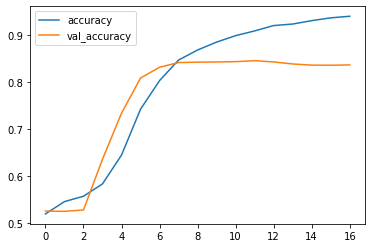

In [38]:
plot_graphs(history,'accuracy')

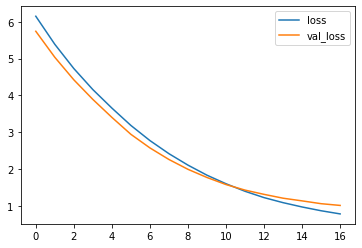

In [39]:
plot_graphs(history,'loss')

# Testing

In [40]:
n = 2651
heads[n],labels[n]

('dept. of transportation to replace highway mile markers with dead raccoons',
 1)

In [41]:
sample = heads[n]

preds = model.predict(np.array([sample]))

In [42]:
np.array(type(heads[n]))

array(<class 'str'>, dtype=object)

In [47]:
preds[0][0]

0.99971455

In [52]:
others = ['Man Returns To Work After Vacation With Fresh, Reenergized Hatred For Job', #yes
          'Queen missed second church service following conversation to Satanism', #yes
          'The Day Dostoyevsky Discovered the Meaning of Life in a Dream', #no
          'Proof Finds That All Change Is a Mix of Order and Randomness', #no
         'Iran Eases Up on Inspections Threat', #no
        'France Still Struggles With the Shadow of the ‘War Without a Name', #no
         'Zuckerberg could make a very good dating app with all the information he has collected about us.', #yes
        'It’s so cold outside that I saw a politician with his hands in his own pocket!' ] #yes

In [53]:
preds1 = model.predict(np.array(others))
preds1

array([[0.9997924 ],
       [0.9991449 ],
       [0.05134534],
       [0.05094009],
       [0.21886411],
       [0.05113244],
       [0.04801257],
       [0.9180333 ]], dtype=float32)

In [48]:
tf.keras.models.save_model(model,"Model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Model\assets


In [51]:
model.save_weights('weights/mod1',save_format='tf')

In [42]:
loaded_model = tf.keras.models.load_model('./saved_model/1',compile=False)

In [55]:
loaded_model.predict(np.array([sample]))

array([[0.99740744]], dtype=float32)

In [56]:
pred = []

In [57]:
type(pred)

list